# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 10</span>

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.optimize import curve_fit
plt.rcParams.update({
    'font.family':'cmr10',
    'mathtext.fontset': 'cm',
    'axes.formatter.use_mathtext': True,
    'axes.axisbelow': True,
    'figure.figsize': [6.0, 6.0],
    'axes.labelsize': 15,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
    'font.size':15,
    'savefig.directory':'./Images'
})

### Exercise 10.1

Choose **ONLY ONE** of the two following possibilities:

1. Parallelize with MPI libraries your Genetic Algorithm code in order to solve the TSP by performing a *Genetic Search* with (up to) 11 **parallel GA searches of the optimal path**:
each node should perform an independent GA search, the so-called *Continent*, **but** every $N_{migr}$ generations the *Continents* should exchange their best individuals randomly.

2. Starting from your Genetic Algorithm code implement a **Parallel Tempering algorithm** (Simulated Annealing with many temperatures). Parallelize with MPI libraries your algorithm in order to solve the TSP where each computing node, up to 11, is characterized by a different temperature or a limited set of temperatures (if you need more than 11 temperatures). Use your genetic operators (except crossover) as trial moves for the Metropolis algorithm and **add a trial move that proposes an exchange of paths among adjacent temperatures (nodes)** (see lecture 8 for the acceptance formula). The candidate solution of the TSP will appear on the node with the lowest temperature.

### Exercise 10.2

Apply your parallel code to the TSP problem for 110 italian "capoluoghi di provincia" longitude and latitude coordinates in the *cap_prov_ita.dat* file.

If your choice in Exercise 10.1 is option 1, do you improve with respect using the same number of computing cores but with **independent GA searches** ?

If your choice in Exercise 10.1 is option 2, by using a number of temperatures equal to the number of individuals in your **non-parallel Genetic Algorithm code**, do you "improve" with respect to it?

In [5]:
#CERCHIO
best = np.loadtxt("OUTPUT/CIRCLE/best_config_iniziale.dat")
x1 = best[:,1]
y1 = best[:,2]

medio = np.loadtxt("OUTPUT/CIRCLE/best_config.dat")
x = medio[:,1]
y = medio[:,2]

plt.figure(1,figsize=(14,7))
plt.subplot(1,2,1)
plt.plot(x1,y1,'o',color='red', linestyle = '--', markersize = 4)
plt.title('Initial path')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(x,y,'o',color='blue', linestyle = '--', markersize = 4)
plt.title('Final path')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)

plt.show()

FileNotFoundError: OUTPUT/CIRCLE/best_config_iniziale.dat not found.

In [ ]:
#quadrato
best = np.loadtxt("OUTPUT/SQUARE/best_config_iniziale.dat")
x1 = best[:,1]
y1 = best[:,2]

medio = np.loadtxt("OUTPUT/SQUARE/best_config.dat")
x = medio[:,1]
y = medio[:,2]

plt.figure(1,figsize=(14,7))
plt.subplot(1,2,1)
plt.plot(x1,y1,'o',color='red', linestyle = '--', markersize = 4)
plt.title('Initial path')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(x,y,'o',color='blue', linestyle = '--', markersize = 4)
plt.title('Final path')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)


plt.show()

NameError: name 'np' is not defined

In [ ]:
#quadrato
best = np.loadtxt("OUTPUT/FILE/best_config_iniziale.dat")
x1 = best[:,1]
y1 = best[:,2]

medio = np.loadtxt("OUTPUT/FILE/best_config.dat")
x = medio[:,1]
y = medio[:,2]

plt.figure(1,figsize=(14,7))
plt.subplot(1,2,1)
plt.plot(x1,y1,'o',color='red', linestyle = '--', markersize = 4)
plt.title('Initial path')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(x,y,'o',color='blue', linestyle = '--', markersize = 4)
plt.title('Final path')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)

plt.show()

NameError: name 'np' is not defined

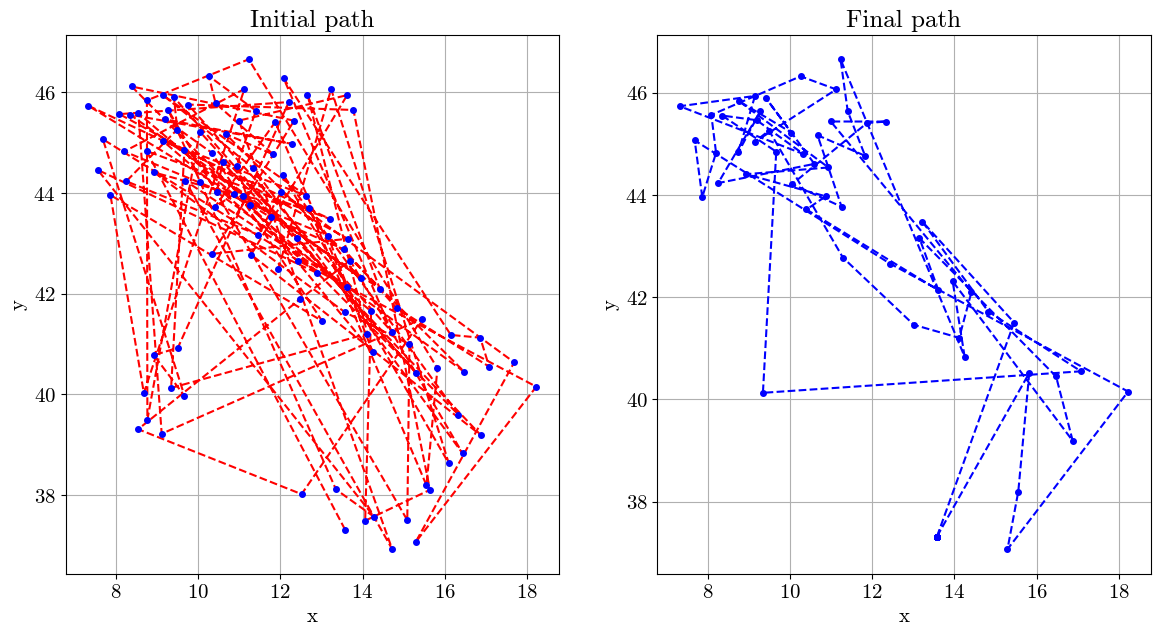

In [ ]:
#quadrato
best = np.loadtxt("OUTPUT/best_config_iniziale.dat")
x1 = best[:,1]
y1 = best[:,2]

medio = np.loadtxt("OUTPUT/best_config.dat")
x = medio[:,1]
y = medio[:,2]

plt.figure(1,figsize=(14,7))
plt.subplot(1,2,1)
plt.plot(x1,y1,'o',color='red', linestyle = '--', markersize = 4, markerfacecolor = 'blue', markeredgecolor = 'blue')
plt.title('Initial path')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(x,y,'o',color='blue', linestyle = '--', markersize = 4)
plt.title('Final path')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)

plt.show()